# Notebook with figures for this work

In [1]:
using Pkg
# cd("/g/data/e14/jb2381/CabbelingExperiments")
# Pkg.activate(@__DIR__)
Pkg.activate(joinpath(@__DIR__, "../"))
using NCDatasets, CairoMakie, TwoLayerDirectNumericalShenanigans, StatsBase, Printf, GibbsSeaWater

  Activating project at `~/Documents/PhD data and code/CabbelingExperiments`


┌ Info: Oceananigans will use 8 threads
└ @ Oceananigans /Users/Joey/.julia/packages/Oceananigans/orOH2/src/Oceananigans.jl:270


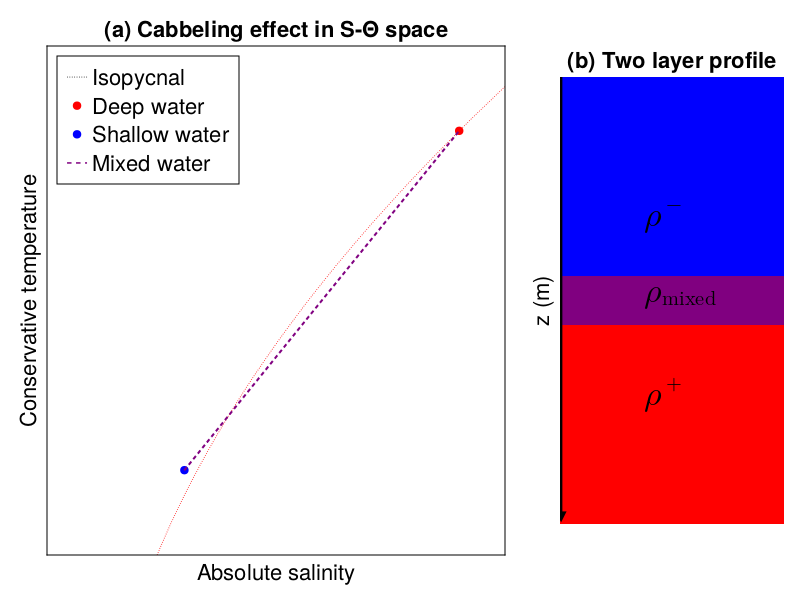

In [51]:
S_star, Θ_star = 34.7, 0.5
S₀ᵘ = 34.58
Θᵘ = -1.5
slope = (Θᵘ - Θ_star) / (S₀ᵘ - S_star)
S_mix = range(S₀ᵘ, S_star, step = 0.000001)
Θ_mix = @. Θᵘ + (slope) * (S_mix - S₀ᵘ)
ρ_mix = gsw_rho.(S_mix, Θ_mix, 0)
max_rho, max_rho_idx = findmax(ρ_mix)
S_max, Θ_max = S_mix[max_rho_idx], Θ_mix[max_rho_idx]
Δρ_mix = max_rho - gsw_rho(S_star, Θ_star, 0)

N = 2000
S_range, Θ_range = range(34.52, 34.72, length = N), range(-2, 1, length = N)
S_grid, Θ_grid = ones(N) .* S_range', ones(N)' .* Θ_range
ρ = gsw_rho.(S_grid, Θ_grid, 0)
ρ_star = gsw_rho(S_star, Θ_star, 0)
ρ_s = gsw_rho(S₀ᵘ, Θᵘ, 0)
find_Θ = findfirst(Θ_range .> -1.5)
find_S = findfirst(ρ[find_Θ, :] .> ρ_star)
S_iso, Θ_iso = S_range[find_S], Θ_range[find_Θ]
gsw_rho(S_iso, Θ_iso, 0)
αₗ, βₗ = gsw_alpha(S_star, Θ_star, 0), gsw_beta(S_star, Θ_star, 0)
m_initial = βₗ / αₗ
Θ_linear_initial = @. Θ_star + m_initial * (S_range - S_star)
αₘ, βₘ = gsw_alpha(S_max, Θ_max, 0), gsw_beta(S_max, Θ_max, 0)
m = βₘ / αₘ
Θ_linear = @. Θ_max + m * (S_range - S_max)
fig = Figure(size = (500, 500), fontsize = 22)
ax = Axis(fig[1, 1];
          title = "(a) Cabbeling effect in S-Θ space",
          xlabel = "Absolute salinity",
          ylabel = "Conservative temperature",
          xticklabelsvisible = false,
          yticklabelsvisible = false,
          xgridvisible = false,
          xticksvisible = false,
          yticksvisible = false,
          ygridvisible = false,
          limits = (extrema(S_range), extrema(Θ_range)))
contour!(ax, S_range, Θ_range, ρ'; levels = [ρ_star], color = :red, 
         linewidth = 0.8, labelsize = 18, linestyle = :dot, label = "Isopycnal")
scatter!(ax, [S_star], [Θ_star], color = :red, label = "Deep water")
scatter!(ax, [S₀ᵘ], [Θᵘ], color = :blue, label = "Shallow water")
lines!(ax, S_mix, Θ_mix, color = :purple, linestyle = :dash, label = "Mixed water")
axislegend(ax, position = :lt)

ax2 = Axis(fig[1, 2],
          title = "(b) Two layer profile",
          aspect = 1/2,
          ylabel = "z (m)",
          yticksvisible = false,
          yticklabelsvisible = false,
          ygridvisible = false)
hidexdecorations!(ax2)
hidespines!(ax2)
data2 = [vcat(fill(0, 4), 1, fill(2, 4)) vcat(fill(0, 4), 1, fill(2, 4))]
hm = heatmap!(ax2, 0:2, 0:10, data2'; colormap = [:red, :purple, :blue])
text!(ax2, 0.75, 6.5,  text = L"ρ^{-}", fontsize = 34)
text!(ax2, 0.75, 2.5,  text = L"ρ^{+}", fontsize = 34)
text!(ax2, 0.75, 4.8,  text = L"ρ_{\mathrm{mixed}}", fontsize = 34)
arrows!(ax2, [0.01], [10], [0], [-1], lengthscale = 9.8, linewidth = 2.5, arrowsize = 15)
colsize!(fig.layout, 1, Aspect(1.0, 9/10))
fig
#save("STfig.png", fig)

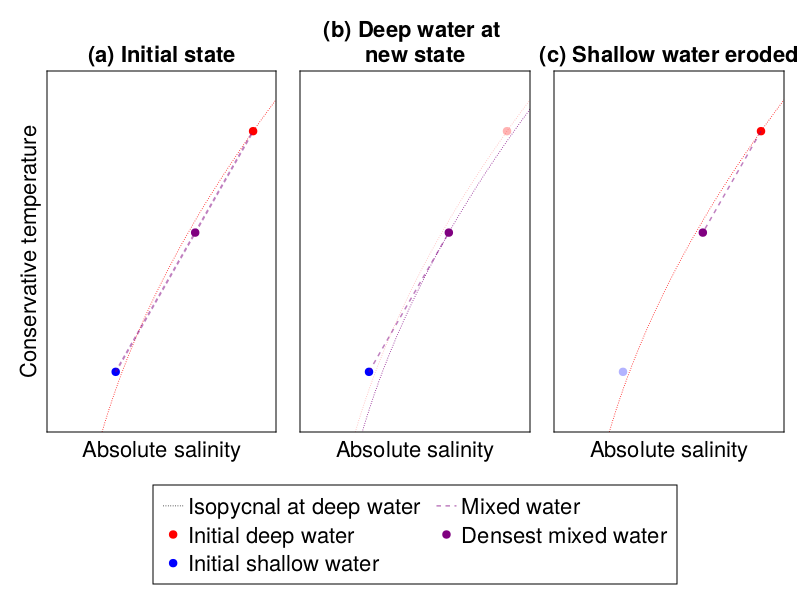

In [52]:
S_star, Θ_star = 34.7, 0.5
S₀ᵘ = 34.58
Θᵘ = -1.5
slope = (Θᵘ - Θ_star) / (S₀ᵘ - S_star)
S_mix = range(S₀ᵘ, S_star, step = 0.000001)
Θ_mix = @. Θᵘ + (slope) * (S_mix - S₀ᵘ)
ρ_mix = gsw_rho.(S_mix, Θ_mix, 0)
max_rho, max_rho_idx = findmax(ρ_mix)
S_max, Θ_max = S_mix[max_rho_idx], Θ_mix[max_rho_idx]
Δρ_mix = max_rho - gsw_rho(S_star, Θ_star, 0)

N = 2000
S_range, Θ_range = range(34.52, 34.72, length = N), range(-2, 1, length = N)
S_grid, Θ_grid = ones(N) .* S_range', ones(N)' .* Θ_range
ρ = gsw_rho.(S_grid, Θ_grid, 0)
ρ_star = gsw_rho(S_star, Θ_star, 0)
ρ_s = gsw_rho(S₀ᵘ, Θᵘ, 0)
find_Θ = findfirst(Θ_range .> -1.5)
find_S = findfirst(ρ[find_Θ, :] .> ρ_star)
S_iso, Θ_iso = S_range[find_S], Θ_range[find_Θ]
gsw_rho(S_iso, Θ_iso, 0)
αₗ, βₗ = gsw_alpha(S_star, Θ_star, 0), gsw_beta(S_star, Θ_star, 0)
m_initial = βₗ / αₗ
Θ_linear_initial = @. Θ_star + m_initial * (S_range - S_star)
αₘ, βₘ = gsw_alpha(S_max, Θ_max, 0), gsw_beta(S_max, Θ_max, 0)
m = βₘ / αₘ
Θ_linear = @. Θ_max + m * (S_range - S_max)
fig = Figure(size = (1000, 800), fontsize = 22)
ax = Axis(fig[1, 1];
          title = "(a) Initial state",
          xlabel = "Absolute salinity",
          ylabel = "Conservative temperature",
          xticklabelsvisible = false,
          yticklabelsvisible = false,
          xticksvisible = false,
          yticksvisible = false,
          xgridvisible = false,
          ygridvisible = false,
          limits = (extrema(S_range), extrema(Θ_range)))
contour!(ax, S_range, Θ_range, ρ'; levels = [ρ_star], color = :red, linewidth = 0.8, 
        labelsize = 18, linestyle = :dot, label = "Isopycnal at deep water")
scatter!(ax, [S_star], [Θ_star], color = :red, label = "Initial deep water")
scatter!(ax, [S₀ᵘ], [Θᵘ], color = :blue, label = "Initial shallow water")
lines!(ax, S_mix, Θ_mix, color = (:purple, 0.5), linestyle = :dash, label = "Mixed water")
scatter!(ax, S_max, Θ_max, color = :purple, label = "Densest mixed water")
#axislegend(ax, position = :lt)

ax2 = Axis(fig[1, 2];
            title = "(b) Deep water at \nnew state",
            xlabel = "Absolute salinity",
            ylabel = "Conservative temperature",
            xticklabelsvisible = false,
            xticksvisible = false,
            xgridvisible = false,
            ygridvisible = false,
            yticksvisible = false,
            limits = (extrema(S_range), extrema(Θ_range)))
contour!(ax2, S_range, Θ_range, ρ'; levels = [max_rho], color = :purple, linewidth = 0.8, 
        labelsize = 18, linestyle = :dot, label = "Isopycnal")
contour!(ax2, S_range, Θ_range, ρ'; levels = [ρ_star], color = (:red, 0.3), linewidth = 0.8, 
        labelsize = 18, linestyle = :dot, label = "Isopycnal")
scatter!(ax2, [S₀ᵘ], [Θᵘ], color = :blue, label = "Shallow water")
scatter!(ax2, [S_star], [Θ_star], color = (:red, 0.3), label = "Initial deep water")
lines!(ax2, [S₀ᵘ, S_max], [Θᵘ, Θ_max], color = (:purple, 0.5), linestyle = :dash, label = "Mixed water")
scatter!(ax2, S_max, Θ_max, color = :purple, label = "New deep water")
hideydecorations!(ax2, grid = false)

ax3 = Axis(fig[1, 3];
            title = "(c) Shallow water eroded",
            xlabel = "Absolute salinity",
            ylabel = "Conservative temperature",
            xticklabelsvisible = false,
            xticksvisible = false,
            xgridvisible = false,
            ygridvisible = false,
            yticksvisible = false,
            limits = (extrema(S_range), extrema(Θ_range)))
contour!(ax3, S_range, Θ_range, ρ'; levels = [ρ_star], color = :red, linewidth = 0.8, 
        labelsize = 18, linestyle = :dot, label = "Isopycnal")
scatter!(ax3, [S_star], [Θ_star], color = :red, label = "Deep water")
lines!(ax3, [S_star, S_max], [Θ_star, Θ_max], color = (:purple, 0.5), linestyle = :dash, label = "Mixed water")
scatter!(ax3, S_max, Θ_max, color = :purple, label = "New deep water water")
scatter!(ax3, [S₀ᵘ], [Θᵘ], color = (:blue, 0.3), label = "Shallow water")
hideydecorations!(ax3, grid = false)

linkyaxes!(ax, ax2, ax3)

Legend(fig[2, :], ax, orientation = :horizontal, nbanks = 3)
fig
#save("new_state_fig.png", fig)